# Laboratorio 3 - Visión por Computadora
## Integrantes:

- Javier Alvarado - 21188
- Mario Guerra - 21008
- Emilio Solano - 21212

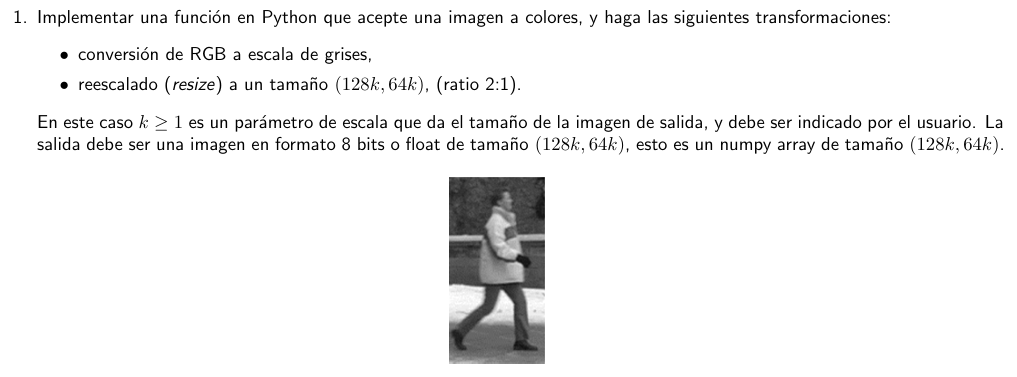

In [40]:
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt

In [4]:
img_bgr = cv2.imread("assets/person.png")
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

def preprocesar_imagen_opencv(ruta_imagen, k=1, out_dtype='uint8'):
    img_bgr = cv2.imread(ruta_imagen)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # Dimensiones de salida
    ancho = 64 * k
    alto  = 128 * k
    
    # Reescalado (OpenCV recibe (ancho, alto))
    resized = cv2.resize(gray, (ancho, alto), interpolation=cv2.INTER_AREA)
    
    if out_dtype == 'float32':
        resized = resized.astype(np.float32) / 255.0
    else:
        resized = resized.astype(np.uint8)

    return resized


In [5]:
def calcular_gradientes(imagen_gray):
    """
    imagen_gray: array 2D numpy con la imagen en escala de grises.
    return: magnitud, orientacion (en radianes o grados).
    """
    grad_x = cv2.Sobel(imagen_gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(imagen_gray, cv2.CV_64F, 0, 1, ksize=3)

    # Magnitud y orientación
    magnitud = np.sqrt(grad_x**2 + grad_y**2)
    orientacion = np.arctan2(grad_y, grad_x)
    
    return magnitud, orientacion


In [6]:
def construir_histogramas_celdas(magnitud, orientacion, celdas=8, bins=9):
    """
    magnitud, orientacion: arrays 2D de la misma forma
    celdas: tamaño en pixeles de la celda (ej. 8)
    bins: número de bins para la orientación (ej. 9)
    return: hist_celdas, un array 3D de forma (num_celdas_vertical, num_celdas_horizontal, bins)
    """
    alto, ancho = magnitud.shape
    num_celdas_y = alto  // celdas
    num_celdas_x = ancho // celdas
    orientacion_grados = np.degrees(orientacion) 
    orientacion_grados[orientacion_grados < 0] += 180

    bin_width = 180 / bins

    # Inicializamos histograma por celda
    hist_celdas = np.zeros((num_celdas_y, num_celdas_x, bins), dtype=np.float32)

    for i in range(num_celdas_y):
        for j in range(num_celdas_x):
            # extraer la región que corresponde a la celda (i,j)
            y_inicio = i * celdas
            y_fin    = y_inicio + celdas
            x_inicio = j * celdas
            x_fin    = x_inicio + celdas

            # Extraer magnitud y orientación en esa celda
            mag_patch = magnitud[y_inicio:y_fin, x_inicio:x_fin]
            ang_patch = orientacion_grados[y_inicio:y_fin, x_inicio:x_fin]

            # Acumular en bins
            for y_local in range(celdas):
                for x_local in range(celdas):
                    ang = ang_patch[y_local, x_local]
                    mag = mag_patch[y_local, x_local]

                    # Determinar el bin principal
                    bin_index = int(ang // bin_width)
                    if bin_index == bins:
                        bin_index = bins - 1

                    hist_celdas[i, j, bin_index] += mag
    return hist_celdas


In [7]:
def normalizar_bloques(hist_celdas, celdas_por_bloque=2, eps=1e-5):
    """
    hist_celdas: array (num_celdas_y, num_celdas_x, bins)
    celdas_por_bloque: normalmente 2 (bloque de 2×2 celdas)
    return: descriptor HOG concatenado en 1D o en 3D, según se necesite
    """
    num_celdas_y, num_celdas_x, bins = hist_celdas.shape
    bloque_stride = 1

    # Número de bloques en horizontal y vertical
    num_bloques_y = (num_celdas_y - celdas_por_bloque) // bloque_stride + 1
    num_bloques_x = (num_celdas_x - celdas_por_bloque) // bloque_stride + 1

    hog_descriptor = []

    for y in range(num_bloques_y):
        for x in range(num_bloques_x):
            block_hist = hist_celdas[y : y + celdas_por_bloque,
                                     x : x + celdas_por_bloque, :]
            block_vector = block_hist.flatten()

            # Normalización L2
            norma = np.sqrt(np.sum(block_vector**2) + eps**2)
            block_vector_norm = block_vector / norma

            hog_descriptor.append(block_vector_norm)

    # Concatenar todos los bloques en un solo vector final
    hog_descriptor = np.concatenate(hog_descriptor)
    return hog_descriptor


In [8]:

def hog_descriptor(ruta_imagen, k=1, celdas=8, bins=9, celdas_por_bloque=2):
    """
    Calcula el descriptor HOG a partir de una imagen en 'ruta_imagen'
    con tamaño de salida 128k×64k.
    """
    # 1. Preprocesado
    img = preprocesar_imagen_opencv(ruta_imagen, k=k, out_dtype='uint8')

    fd, hog_image = hog(img,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    visualize=True,
                    block_norm='L2-Hys')

    plt.imshow(hog_image, cmap='gray')
    plt.show()

    # 2. Gradientes
    magnitud, orientacion = calcular_gradientes(img)

    # 3. Histograma por celdas
    hist_celdas = construir_histogramas_celdas(magnitud, orientacion,
                                               celdas=celdas,
                                               bins=bins)
    # 4. Normalización por bloques
    hog_vec = normalizar_bloques(hist_celdas, celdas_por_bloque=celdas_por_bloque)
    
    return hog_vec


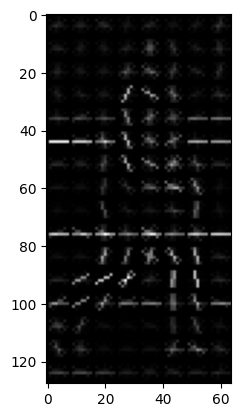

HOG descriptor shape: (3780,)
Primera parte del descriptor: [0.21855353 0.14436023 0.25222066 0.18484703 0.25530457 0.24603745
 0.0366067  0.06692467 0.15302928 0.08399129]


In [9]:
ruta = "assets/person.png"

descriptor_hog = hog_descriptor(ruta_imagen=ruta, k=1,
                                    celdas=8, bins=9, celdas_por_bloque=2)



print("HOG descriptor shape:", descriptor_hog.shape)
print("Primera parte del descriptor:", descriptor_hog[:10])

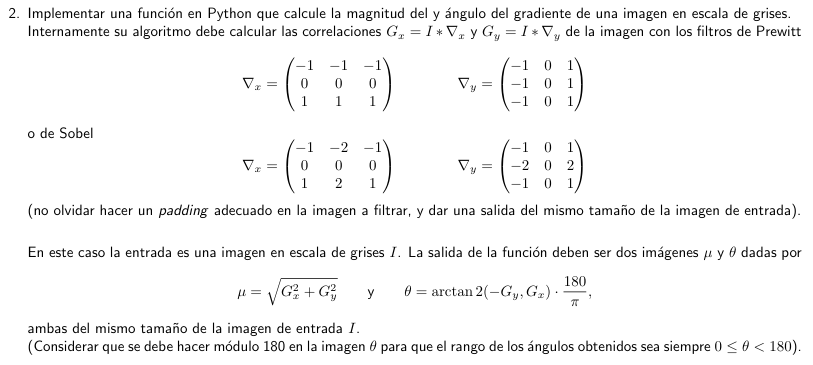

In [10]:
sobel_x = np.array([[-1,  0,  1],
                    [-2,  0,  2],
                    [-1,  0,  1]], dtype=np.float32)

sobel_y = np.array([[ 1,  2,  1],
                    [ 0,  0,  0],
                    [-1, -2, -1]], dtype=np.float32)

prewitt_x = np.array([[-1,  0,  1],
                      [-1,  0,  1],
                      [-1,  0,  1]], dtype=np.float32)

prewitt_y = np.array([[ 1,  1,  1],
                      [ 0,  0,  0],
                      [-1, -1, -1]], dtype=np.float32)


In [11]:
def gradiente(imagen_gray, method='sobel'):
    """
    Calcula la magnitud y el ángulo del gradiente de 'imagen_gray'
    usando filtros de Sobel o de Prewitt.
    
    Parámetros:
    -----------
    imagen_gray : np.ndarray
        Imagen en escala de grises (uint8 o float).
    method : str
        'sobel' o 'prewitt'.
    
    Retorna:
    --------
    G : np.ndarray
        Magnitud del gradiente (mismo tamaño que 'imagen_gray').
    theta : np.ndarray
        Ángulo del gradiente en grados, en [0, 180).
    """

    # Definir kernels
    if method.lower() == 'sobel':
        kx = np.array([[-1,  0,  1],
                       [-2,  0,  2],
                       [-1,  0,  1]], dtype=np.float32)
        ky = np.array([[ 1,  2,  1],
                       [ 0,  0,  0],
                       [-1, -2, -1]], dtype=np.float32)
    elif method.lower() == 'prewitt':
        kx = np.array([[-1,  0,  1],
                       [-1,  0,  1],
                       [-1,  0,  1]], dtype=np.float32)
        ky = np.array([[ 1,  1,  1],
                       [ 0,  0,  0],
                       [-1, -1, -1]], dtype=np.float32)
    else:
        raise ValueError("method debe ser 'sobel' o 'prewitt'")

    # Aplicar correlación en X e Y con padding que conserve dimensiones
    Gx = cv2.filter2D(src=imagen_gray, ddepth=cv2.CV_64F, kernel=kx,
                      borderType=cv2.BORDER_REPLICATE)
    Gy = cv2.filter2D(src=imagen_gray, ddepth=cv2.CV_64F, kernel=ky,
                      borderType=cv2.BORDER_REPLICATE)

    # Calcular magnitud
    G = np.sqrt(Gx**2 + Gy**2)

    # Calcular ángulo en grados
    theta = np.arctan2(Gy, Gx) * 180.0 / np.pi
    theta[theta < 0] += 180.0

    return G, theta


Tamaño de la imagen original: (585, 300)
Tamaño de la magnitud (Sobel): (585, 300)
Tamaño del ángulo (Sobel): (585, 300)


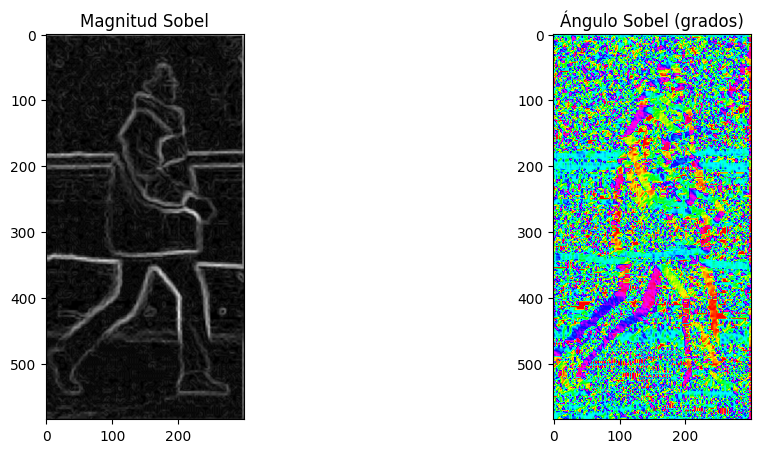

In [12]:
# Cargar la imagen en escala de grises
imagen_gray = cv2.imread("./assets/person.png", cv2.IMREAD_GRAYSCALE)

# Calcular gradiente con Sobel
magnitud_sobel, angulo_sobel = gradiente(imagen_gray, method='sobel')

# Calcular gradiente con Prewitt
magnitud_prewitt, angulo_prewitt = gradiente(imagen_gray, method='prewitt')

# Verificar dimensiones
print("Tamaño de la imagen original:", imagen_gray.shape)
print("Tamaño de la magnitud (Sobel):", magnitud_sobel.shape)
print("Tamaño del ángulo (Sobel):", angulo_sobel.shape)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Magnitud Sobel")
plt.imshow(magnitud_sobel, cmap='gray')

plt.subplot(1,2,2)
plt.title("Ángulo Sobel (grados)")
plt.imshow(angulo_sobel, cmap='hsv')
plt.show()


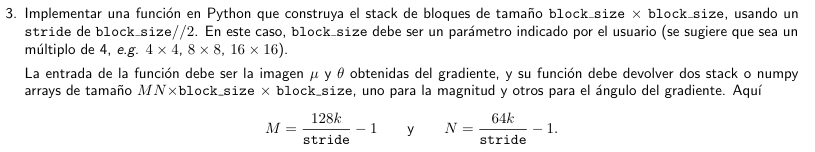

In [13]:
def build_blocks(mu, theta, block_size):
    """
    Entrada:
    - mu: Matriz 2D con las magnitudes del gradiente.
    - theta: Matriz 2D con los ángulos del gradiente (en grados).
    - block_size: Tamaño de los bloques.

    Salida:
    - blocks_mu: Array 3D de tamaño (M*N, block_size, block_size) con bloques de magnitud.
    - blocks_theta: Array 3D de tamaño (M*N, block_size, block_size) con bloques de ángulo.
    """

    # Definir stride como la mitad del tamaño del bloque (desplazamiento entre bloques)
    stride = block_size // 2
    height, width = mu.shape  # Dimensiones de la imagen

    # Calcular la cantidad de bloques en vertical (M) y horizontal (N)
    M = (height - block_size) // stride + 1
    N = (width - block_size) // stride + 1

    # Inicializar arrays para almacenar los bloques
    blocks_mu = np.zeros((M * N, block_size, block_size))
    blocks_theta = np.zeros((M * N, block_size, block_size))

    # Recorrer la imagen con pasos de "stride" y extraer bloques
    idx = 0
    for i in range(0, height - block_size + 1, stride):
        for j in range(0, width - block_size + 1, stride):
            # Extraer bloque de tamaño block_size x block_size para magnitud y ángulo
            blocks_mu[idx] = mu[i:i+block_size, j:j+block_size]
            blocks_theta[idx] = theta[i:i+block_size, j:j+block_size]
            idx += 1  # Avanzar índice para almacenar siguiente bloque

    return blocks_mu, blocks_theta

In [14]:
block_size = 8 # Tamaño del bloque
mu = magnitud_sobel
theta = angulo_sobel

# Construir stack de bloques
blocks_mu, blocks_theta = build_blocks(mu, theta, block_size)

# Resultados
print(f"Número de bloques: {blocks_mu.shape[0]}")
print(f"Tamaño de cada bloque: {blocks_mu.shape[1]}x{blocks_mu.shape[2]}")
print(f"Resultado de array de bloques de magnitud: {blocks_mu}\n\n")
print(f"Resultado de array de bloques de ángulo: {blocks_theta}")

Número de bloques: 10730
Tamaño de cada bloque: 8x8
Resultado de array de bloques de magnitud: [[[ 84.01190392  86.03487665  84.1546196  ...  76.          76.10519036
    76.4198927 ]
  [166.76930173 165.13025162 161.20794025 ... 148.         149.03019828
   152.11837496]
  [ 85.90692638  90.62008607  90.62008607 ...  88.02272434  93.00537619
   100.        ]
  ...
  [ 62.12889827  56.56854249  47.85394446 ...  32.24903099  27.45906044
    19.23538406]
  [ 35.0142828   31.01612484  24.         ...  37.65634077  34.05877273
    22.        ]
  [ 18.11077028  13.92838828   9.89949494 ...  40.          35.0142828
    20.39607805]]

 [[ 76.          76.          76.10519036 ...  82.60750571  84.09518417
    84.        ]
  [149.00335567 148.         149.03019828 ... 163.07666909 167.02694393
   168.        ]
  [ 85.00588215  88.02272434  93.00537619 ... 110.         113.00442469
   111.04053314]
  ...
  [ 38.18376618  32.24903099  27.45906044 ...  17.49285568  12.72792206
    35.12833614]
  

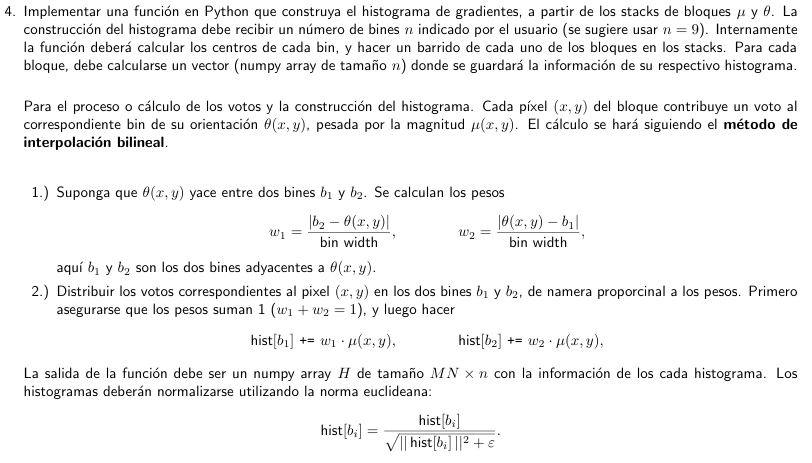

In [15]:
def compute_histogram(blocks_mu, blocks_theta, n_bins=9):
    """
    Entrada:
        blocks_mu: Array de bloques de magnitud
        blocks_theta: Array de bloques de ángulo
        n_bins: Número de bines
    Salida:
        histograms: Array con los histogramas normalizados
    """
    bin_width = 180 / n_bins
    eps = 1e-6  # Para evitar división por cero

    num_blocks = blocks_mu.shape[0]
    histograms = np.zeros((num_blocks, n_bins))

    for b in range(num_blocks):
        mu_block = blocks_mu[b]
        theta_block = blocks_theta[b]

        for i in range(mu_block.shape[0]):
            for j in range(mu_block.shape[1]):
                mag = mu_block[i, j]
                angle = theta_block[i, j] % 180  # Asegurarse que está en [0,180)

                # Índices de bins más cercanos
                bin_index = angle / bin_width
                b1 = int(np.floor(bin_index)) % n_bins
                b2 = (b1 + 1) % n_bins

                # Pesos por interpolación bilineal
                w2 = bin_index - np.floor(bin_index)
                w1 = 1 - w2

                # Votar por los dos bins
                histograms[b, b1] += w1 * mag
                histograms[b, b2] += w2 * mag

        # Normalizar histograma con norma L2
        norm = np.linalg.norm(histograms[b]) + eps
        histograms[b] /= norm

    return histograms


In [16]:
block_size = 8
n_bins = 9

blocks_mu, blocks_theta = build_blocks(mu, theta, block_size)
histograms = compute_histogram(blocks_mu, blocks_theta, n_bins)

print(f"Shape del stack de bloques (mu): {blocks_mu.shape}")
print(f"Shape del histograma final: {histograms.shape}")
print(f"Array completo del histograma final: {histograms}")

Shape del stack de bloques (mu): (10730, 8, 8)
Shape del histograma final: (10730, 9)
Array completo del histograma final: [[0.10865769 0.0603029  0.03906988 ... 0.05153684 0.03635488 0.01212269]
 [0.16370688 0.07698492 0.04817822 ... 0.01998159 0.02061041 0.02750711]
 [0.12198563 0.05614478 0.03721273 ... 0.04789675 0.05429512 0.06010544]
 ...
 [0.09172746 0.09096414 0.10041782 ... 0.47846465 0.09746124 0.09564395]
 [0.02829273 0.01419711 0.0319452  ... 0.50171237 0.1501146  0.03564093]
 [0.58194475 0.00571753 0.01890782 ... 0.10604012 0.13891179 0.77016619]]


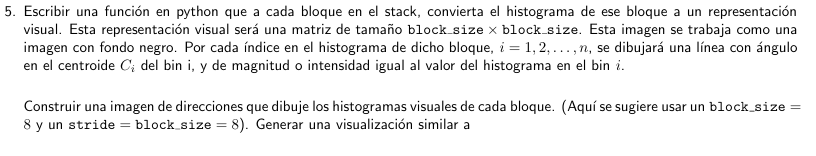

In [ ]:
import numpy as np
import cv2

def draw_histogram(histogram, block_size=8, n_bins=9):
    """    
    Entrada:
        histogram: Vector de tamaño (n_bins,) con los valores del histograma.
        block_size: Tamaño del bloque (anchura y altura de la imagen generada).
        n_bins: Número de bins en el histograma.
    
    Salida:
        img: Imagen en escala de grises con las líneas representando el histograma.
    """
    img = np.zeros((block_size, block_size), dtype=np.uint8)
    center = (block_size // 2, block_size // 2)
    bin_width = 180 / n_bins

    max_mag = np.max(histogram) if np.max(histogram) > 0 else 1

    for i in range(n_bins):
        angle = np.deg2rad(i * bin_width)
        magnitude = (histogram[i] / max_mag) * (block_size // 2)  # Normalizar magnitud
        
        x_offset = int(np.cos(angle) * magnitude)
        y_offset = int(np.sin(angle) * magnitude)

        pt1 = (center[0] - x_offset, center[1] - y_offset)
        pt2 = (center[0] + x_offset, center[1] + y_offset)

        cv2.line(img, pt1, pt2, 255, 1)

    return img

In [18]:
block_size = 8
n_bins = 9
random_histogram = np.random.rand(n_bins)

visual_block = draw_histogram(random_histogram, block_size, n_bins)

In [38]:
visual_block

array([[  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 255,   0,   0,   0,   0,   0],
       [  0,   0,   0, 255, 255,   0, 255,   0],
       [  0, 255, 255, 255, 255, 255, 255,   0],
       [  0,   0,   0, 255, 255, 255,   0,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255],
       [  0,   0, 255,   0, 255, 255,   0,   0],
       [  0,   0,   0,   0,   0,   0, 255,   0]], dtype=uint8)

In [ ]:
def build_direction_image(histograms, img_shape, block_size=8, n_bins=9):
    """
    Entrada:
        histograms: Array de tamaño (num_blocks, n_bins) con los histogramas normalizados.
        img_shape: Tamaño de la imagen original (altura, anchura).
        block_size: Tamaño de cada bloque.
        n_bins: Número de bins en el histograma.
    
    Salida:
        direction_img: Imagen combinada de todas las representaciones visuales de histogramas.
    """
    img_h, img_w = img_shape
    grid_h, grid_w = img_h // block_size, img_w // block_size

    direction_img = np.zeros((img_h, img_w), dtype=np.uint8)

    block_idx = 0
    for i in range(grid_h):
        for j in range(grid_w):
            if block_idx >= histograms.shape[0]:
                break
            
            hist_img = draw_histogram(histograms[block_idx], block_size, n_bins)

            y_start, x_start = i * block_size, j * block_size
            direction_img[y_start:y_start + block_size, x_start:x_start + block_size] = hist_img

            block_idx += 1

    return direction_img

In [ ]:
# Imagen original de 256x256 píxeles
img_shape = (256, 256)
num_blocks = (img_shape[0] // block_size) * (img_shape[1] // block_size)

# Simulando histogramas aleatorios por cada bloque
simulated_histograms = np.random.rand(num_blocks, n_bins)

# Generar imagen de direcciones
direction_image = build_direction_image(simulated_histograms, img_shape, block_size, n_bins)

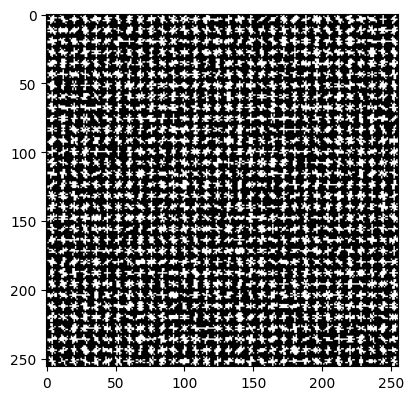

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(direction_image, cmap='gray')
plt.show()

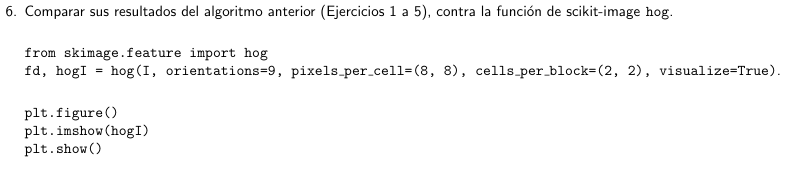

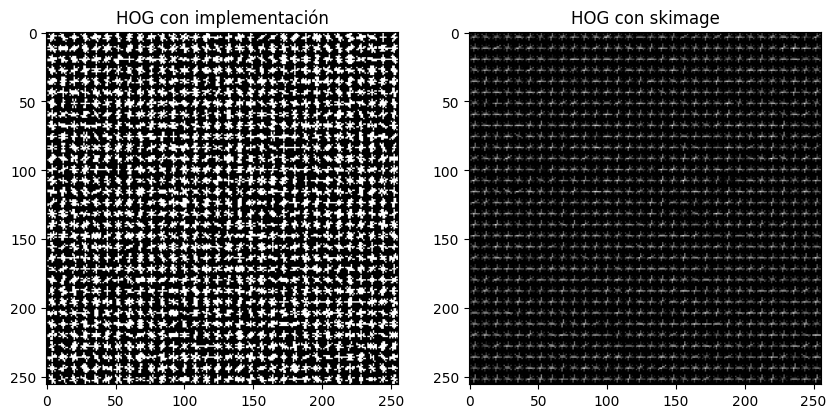

In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import hog

# Calculando HOG
fd, hogI = hog(direction_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("HOG con implementación")
plt.imshow(direction_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("HOG con skimage")
plt.imshow(hogI, cmap='gray')

plt.show()

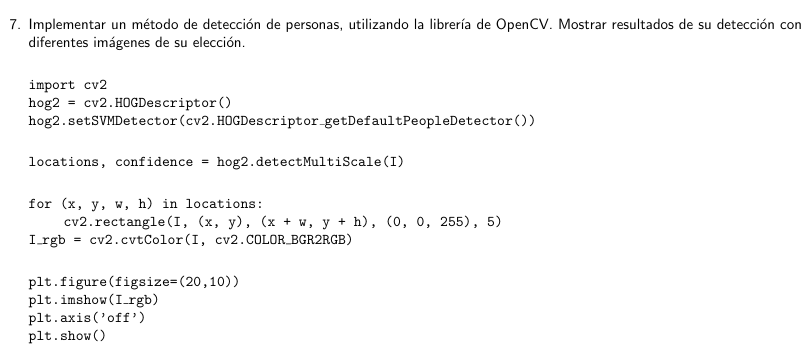

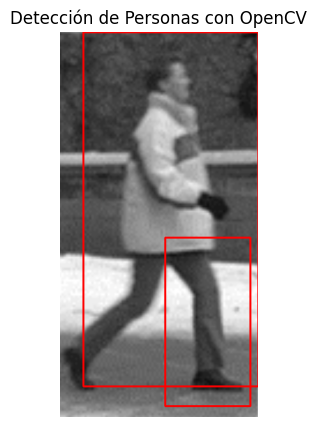

In [ ]:
# Cargar imagen de prueba
I = cv2.imread("./assets/person.png")
I_gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

hog2 = cv2.HOGDescriptor()
hog2.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

locations, _ = hog2.detectMultiScale(I_gray, winStride=(5, 5), padding=(5, 5), scale=1.05)

for (x, y, w, h) in locations:
    cv2.rectangle(I, (x, y), (x + w, y + h), (0, 0, 255), 2)

I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.imshow(I_rgb)
plt.axis('off')
plt.title("Detección de Personas con OpenCV")
plt.show()